# Importing Dataset and Packages

In [1]:
from utils import *

In [2]:
#Importing Datasets
train_trend = pd.read_csv('train_trend.csv')
test_trend = pd.read_csv('test_trend.csv')

#Changing date to date_time object
train_trend.date = pd.to_datetime(train_trend.date)
test_trend.date = pd.to_datetime(test_trend.date)

# Forecasts

## Baseline Model - Holt Winters' Triple Exponential Smoothing Forecast 

The Holt Winters Triple Exponential Smoothing model can be used for datasets with both trend and seasonality. A future prediction is a weighted sum of past observations, but more weight is given to the more recent observations and exponentially smaller weights are applied as the observations go further back in time.

Since the alpha, beta and gamma parameters are automatically optimised, we just have to add the annual seasonality representation in the model, by setting seasonal_periods to 365. We also set seasonal to additive, given that our data did not show exponentially increasing trend.

In [3]:
warnings.filterwarnings("ignore")

#Fitting model

model = ExponentialSmoothing(train_trend.units, seasonal = 'add',\
                             seasonal_periods = 365)
model_fit = model.fit()

#Making predictions
ets_forecast = model_fit.predict(len(train_trend.units)+1, \
                                 len(train_trend.units)+len(test_trend.units))

## Prophet Forecast

[Prophet](https://facebook.github.io/prophet/) is an open source forecasting model by Facebook with intuitive parameters to tune the model. This model is conceptually similar to a Generalized Additive Model (GAM), where a class of regression models is combined, with non-linear smoothing techniques applied to the regressors. Hence, Prophet uses a machine-learning approach to forecasting.

To avoid the risk of overfitting, I used their default parameters as suggested by their [website](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html), which automatically runs weekly seasonality. I chose not to add the other variables (like annual and daily seasonality) in the model fitting because they were already included in our features. I added the extra regressors to include the exogenous variables/features in our model and I made them multiplicative, following the sample code notebook provided on their website.

In [4]:
#Modifying column labels for Prophet
#Prophet can only take the data with these headings

prophet_train_trend = train_trend.copy()
prophet_train_trend['ds'] = prophet_train_trend.date
prophet_train_trend['y'] = prophet_train_trend.units
prophet_train_trend.drop(['date', 'units'],axis = 1, inplace = True)
prophet_train_trend.set_index('ds')


prophet_test_trend = test_trend.copy()
prophet_test_trend['ds'] = prophet_test_trend.date
prophet_test_trend.drop(['date', 'units'],axis = 1, inplace = True)
prophet_test_trend.set_index('ds')



#Initialising model
prophet_model = Prophet()

#Adding exogenous variables, excluding the date and demand units
for i in range(len(prophet_train_trend.columns)):
    if prophet_train_trend.columns[i] == 'ds' \
    or prophet_train_trend.columns[i] == 'y':
        pass
    else:
        prophet_model.add_regressor(prophet_train_trend.columns[i],\
                                    mode='multiplicative')

#Fitting model
prophet_model.fit(prophet_train_trend)

#Making predictions
forecast = prophet_model.predict(prophet_test_trend)

# #Plotting components of the forecast
# prophet_model.plot_components(forecast)

# Optional Plotly Figure of Prophet's Forecast
# py.init_notebook_mode()

# fig = plot_plotly(prophet_model, forecast)  # This returns a plotly Figure
# py.iplot(fig)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Evaluation

As highlighted in the paper, the main metric for evaluating the performance of the models is Cost of Forecast Error (CFE), which gives a dollar value of how much of the supermarket loses in total due to forecast inaccuracy, whether through overstock or understock costs. This metric is especially useful for the business audience.

I assume each good costs **$3.50**.

I assume that the cost of overstock would be the sales the supermarket would have made from the goods (had they not spoilt) plus an extra cost of disposing the goods or giving them to charity. Hence, cost of overstock - **$5**. 

The cost of understock would be the sales the supermarket would have made from the sales of the goods, had they been in stock plus the cost of losing a customer due to the inavailability of the goods, which is the future amount we would have gotten from them if they had continued coming to the store (estimated to be about 3 times in the time period in consideration and slightly discounted). Hence, cost of understock - **$12.50**.

I would also be using Mean Absolute Error(MAE) as the second metric for evaluating the models, coming from the statistical perspective. From the metrics used in scholarly literature, this is the most relevant metric for this problem, after the Cost of Forecast Error.

The lower the CFE and MAE, the better.

## Holt Winters' Forecast

Holt Winters' Forecast Results 
Cost of forecast error is: $ 315945.0
Mean absolute error is: 177.0




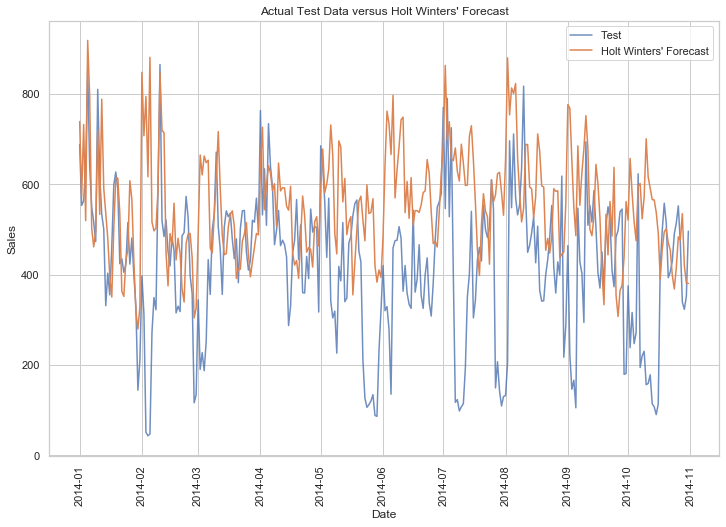

Date with largest residual is:
2014-02-05 00:00:00


Autocorrelation and Partial Autocorrelation Plot of Residuals


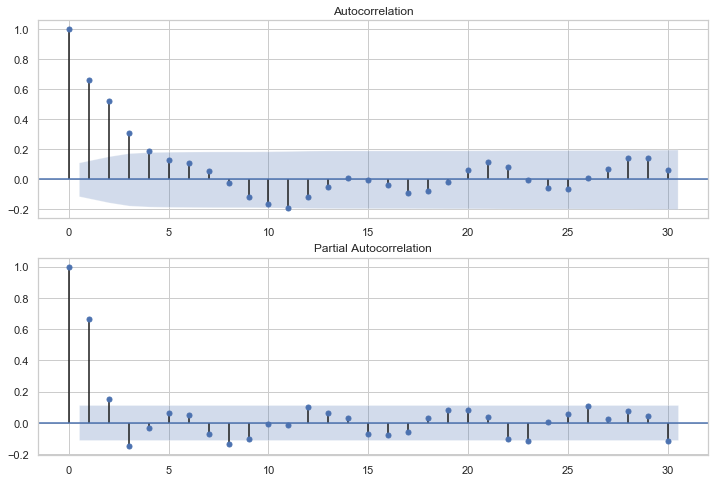

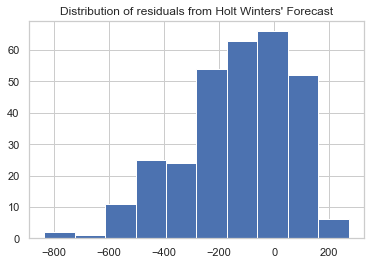

In [5]:
plotting_and_evaluating_results("Holt Winters' Forecast", test_trend.units, \
                                test_trend.date, list(ets_forecast))

#Unfortunately, I could not figure out how to create confidence intervals for this model, 
#as the functionality seems to only be present in R.

## Prophet Forecast

Prophet Forecast Results 
Cost of forecast error is: $ 251885.0
Mean absolute error is: 89.0




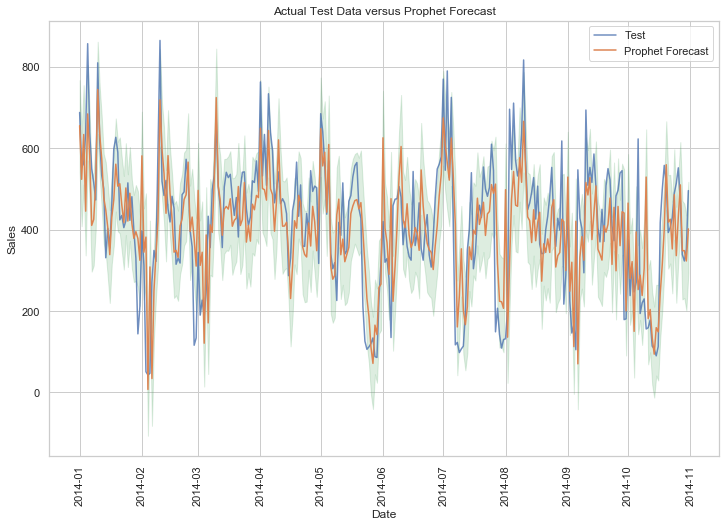

Date with largest residual is:
2014-09-06 00:00:00


Autocorrelation and Partial Autocorrelation Plot of Residuals


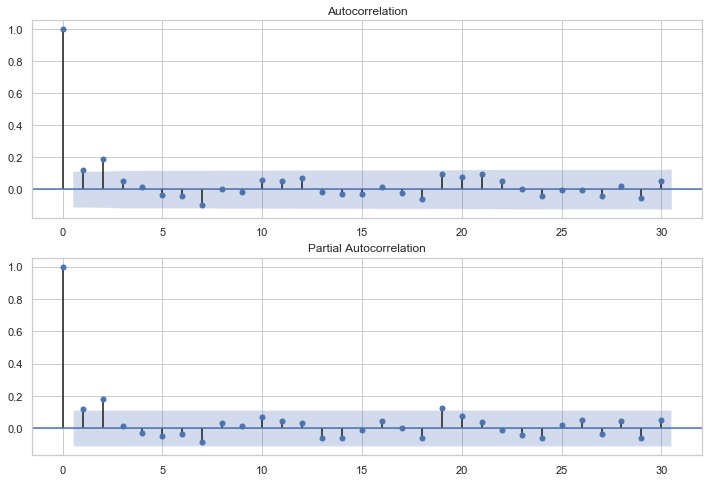

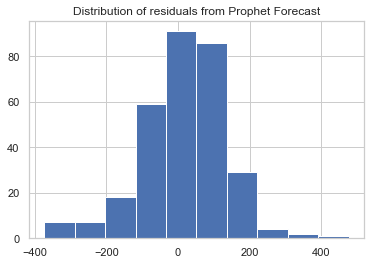

In [6]:
plotting_and_evaluating_results('Prophet Forecast', test_trend.units, \
                                test_trend.date,forecast.yhat, \
                                forecast.yhat_lower, forecast.yhat_upper)

### Discussion + interpretation of results

Looking at the plots above that show the Holt-Winters and Prophet forecasts against the actual test set, we can see that as hypothesized, Prophet greatly outperformed the Holt-Winters model on the two metrics of CFE and MAE, which goes to show how adding relevant features can greatly improve our model accuracy. 

The implementation of the Prophet model to forecast the demand of this product, instead of the Holt Winters model would have saved the supermarket **$64060**. The Mean Average Error would also have been reduced by half, which is quite significant as well.

Evaluating the residuals of models is another way to critically analyse if the models are performing optimally. The residuals are the difference between the actual data and the forecasts. According to Hyndman & Athanasopoulos, (2018), a good forecasting method would yield uncorrelated residuals (which we can see with the autocorrelation plots) because it would show that there is some information left in the residuals that should have been used in making the forecasts, and they should have a zero mean to show the models are not biased. It would also be good for them to be normally distributed.

Looking at the autocorrelation plots above, we can see that the Holt-Winters model yielded uncorrelated residuals, compared to the Prophet model, showing that there was some uncaptured information left by the Holt Winters model that should have been used for the forecast. Prophet’s use of exogenous variables helped it capture that information. Looking at the figures above showing thr distribution of residuals for both models, we can see that the Holt-Winters model is biased as its distribution of residuals does not have a zero mean and is skewed, while Prophet’s residuals, on the other hand, have a zero mean and are normally distributed, showing a lack of bias in the model.

## Feature Importance for Prophet Calculated Using Beta Coefficients

In [7]:
#Dropping columns not in dataset
prophet_model.train_component_cols = prophet_model.train_component_cols.\
drop(columns = ['additive_terms', 'extra_regressors_multiplicative',\
                'multiplicative_terms', 'weekly'])


#Getting the appropriate beta co-efficient for each feature

beta_coefficients = []

for i in range(len(prophet_model.train_component_cols.columns)):
    index = np.where(prophet_model.train_component_cols.iloc[:,i] ==1)[0][0]
    beta_coefficients.append(round(list(prophet_model.params['beta'][0])[index],2))
    

#Making dataframe to show the features and their corresponding beta co-efficient
beta_dataframe = pd.DataFrame(prophet_model.train_component_cols.columns)
beta_dataframe['beta_coefficients'] = beta_coefficients
beta_dataframe = beta_dataframe.sort_values(by='beta_coefficients',\
                                            ascending=False)
beta_dataframe

,component,beta_coefficients
36,day_of_week_6,0.81
39,is_weekend,0.81
0,day_of_month_1,0.60
1,day_of_month_10,0.42
26,day_of_month_5,0.32
...,...,...
28,day_of_month_7,-0.18
25,day_of_month_4,-0.22
27,day_of_month_6,-0.26
33,day_of_week_3,-0.31
